In [1]:
# Import the necessary libraries that are being used below
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, RNN, GRU, Input, Reshape, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import seaborn as sns

In [4]:
# readinag given csv file
# and creating dataframe
df = pd.read_csv("Multi_labeled_CAN_dataset.csv" )

In [5]:
df

,Timestamp,ID,DLC,DATA,Class
0,0.000000e+00,0000 000,8,00 00 00 00 00 00 00 00,1
1,2.710000e-04,0080 000,8,00 17 dc 09 16 11 16 bb,1
2,4.950000e-04,0000 000,8,00 00 00 00 00 00 00 00,1
3,7.360000e-04,0081 000,8,40 84 87 00 00 00 00 6b,1
4,9.830000e-04,0000 000,8,00 00 00 00 00 00 00 00,1
...,...,...,...,...,...
4613434,1.481193e+09,05e4 000,3,00 02 00,3
4613435,1.481193e+09,0153 000,8,00 80 10 ff 00 ff a0 2e,3
4613436,1.481193e+09,0165 000,8,0e d8 7f 00 00 00 03 aa,3
4613437,1.481193e+09,0220 000,8,f4 03 f7 03 0c 00 3a 10,3


In [6]:

label_encoder = LabelEncoder()
df['ID'] = label_encoder.fit_transform(df['ID'])
df['DATA'] = label_encoder.fit_transform(df['DATA'])
X = df[['Timestamp', 'ID', 'DLC', 'DATA']].values
y = df['Class'].values

# Normalize the features using StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [7]:
# Reshape the input data to have a temporal dimension
X = X.reshape(X.shape[0], 1, X.shape[1])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train[0]

array([[1.90641627, 1.26286353, 0.26311474, 1.0702318 ]])

In [13]:
inputs = Input(shape=(X.shape[1], X.shape[2]))
gru_output = GRU(64, return_sequences=True)(inputs)
# gru_output = Dropout(0.5)(gru_output)
# attention = Attention()([gru_output, gru_output])

# # Concatenate the GRU output and the attention output
# context_vector = Concatenate(axis=-1)([gru_output, attention])

# # Flatten the context vector
# flattened_context = tf.keras.layers.Flatten()(context_vector)

# Pass through Dense layer
dense_output = Dense(8, activation='relu')(gru_output)
final_output = Dense(4, activation = 'softmax')(dense_output)
output = Reshape((4,))(final_output)

# Define the model
model = Model(inputs=inputs, outputs=output)
# model.add(Dense(8, activation='ReLU'))
# model.add(Dense(4, activation = 'softmax'))
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 gru_2 (GRU)                 (None, 1, 64)             13440     
                                                                 
 dense_4 (Dense)             (None, 1, 8)              520       
                                                                 
 dense_5 (Dense)             (None, 1, 4)              36        
                                                                 
 reshape_2 (Reshape)         (None, 4)                 0         
                                                                 
Total params: 13996 (54.67 KB)
Trainable params: 13996 (54.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train, y_train, epochs=50, batch_size=256, validation_split=0.1)

Epoch 1/50
14598/14598 [==============================] - 59s 4ms/step - loss: 0.5023 - accuracy: 0.8225 - val_loss: 0.4613 - val_accuracy: 0.8406
Epoch 2/50
14598/14598 [==============================] - 56s 4ms/step - loss: 0.4453 - accuracy: 0.8483 - val_loss: 0.4312 - val_accuracy: 0.8512
Epoch 3/50
14598/14598 [==============================] - 56s 4ms/step - loss: 0.4199 - accuracy: 0.8584 - val_loss: 0.4143 - val_accuracy: 0.8595
Epoch 4/50
14598/14598 [==============================] - 56s 4ms/step - loss: 0.4069 - accuracy: 0.8615 - val_loss: 0.4020 - val_accuracy: 0.8628
Epoch 5/50
14598/14598 [==============================] - 55s 4ms/step - loss: 0.3980 - accuracy: 0.8648 - val_loss: 0.3961 - val_accuracy: 0.8642
Epoch 6/50
14598/14598 [==============================] - 55s 4ms/step - loss: 0.3911 - accuracy: 0.8673 - val_loss: 0.3898 - val_accuracy: 0.8671
Epoch 7/50
14598/14598 [==============================] - 56s 4ms/step - loss: 0.3868 - accuracy: 0.8680 - val_loss: 0

In [16]:
import pickle

with open('history', 'wb') as file_pi:
    pickle.dump(hist.history, file_pi)

In [17]:
# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(hist.history)

# save to json:
# hist_json_file = 'history.json'
# with open(hist_json_file, mode='w') as f:
#     hist_df.to_json(f)

# or save to csv:
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

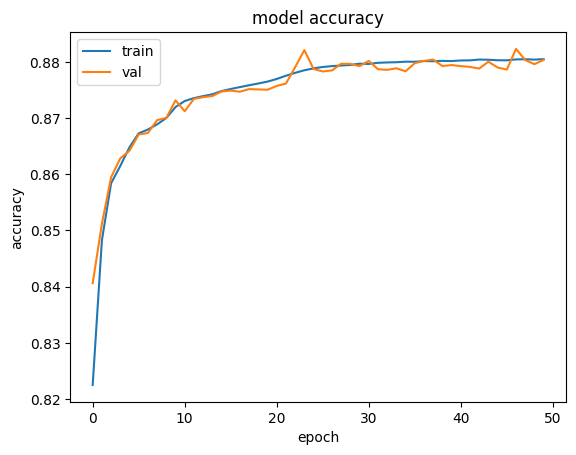

In [18]:
import matplotlib.pyplot as plt


# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs=range(1,len(loss)+1)
# plt.plot(epochs, loss, 'b.', label='training loss')
# plt.plot(epochs, val_loss, 'r.', label='validate loss')
# plt.title('training loss vs validation loss')
# plt.xlabel('epochs')
# plt.ylabel('loss')
# plt.legend()
# plt.show()


plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

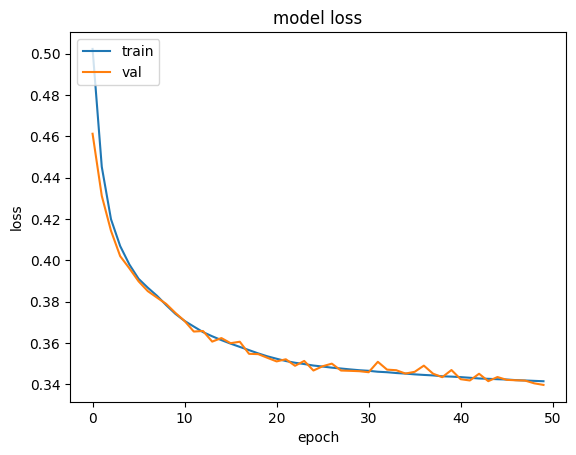

In [19]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
predicted_result = model.predict(X_test)

14417/14417 [==============================] - 21s 1ms/step


In [21]:
predicted = [np.argmax(i) for i in predicted_result]
predicted

[0,
 0,
 0,
 3,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 3,
 0,
 0,
 3,
 3,
 1,
 0,
 0,
 3,
 0,
 3,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 2,
 0,
 0,
 3,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 3,
 1,
 3,
 3,
 1,
 0,
 3,
 2,
 0,
 3,
 3,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 2,
 0,
 0,
 0,
 3,
 3,
 0,
 1,
 1,
 0,
 3,
 2,
 0,
 0,
 3,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 2,
 0,
 3,
 0,
 0,
 0,
 3,
 0,
 3,
 3,
 0,
 0,
 2,
 0,
 1,
 0,
 3,
 3,
 0,
 0,
 0,
 1,
 0,
 3,
 0,
 3,
 0,
 0,
 0,
 3,
 0,
 0,
 3,
 3,
 2,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 3,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 3,
 0,
 3,
 0,
 1,
 0,
 3,
 0,
 3,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 3,
 1,
 0,
 1,
 0,
 0,
 0,
 3,
 0,
 3,
 0,
 0,
 0,
 0,


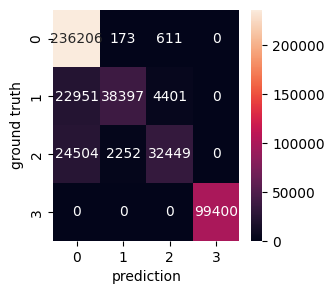

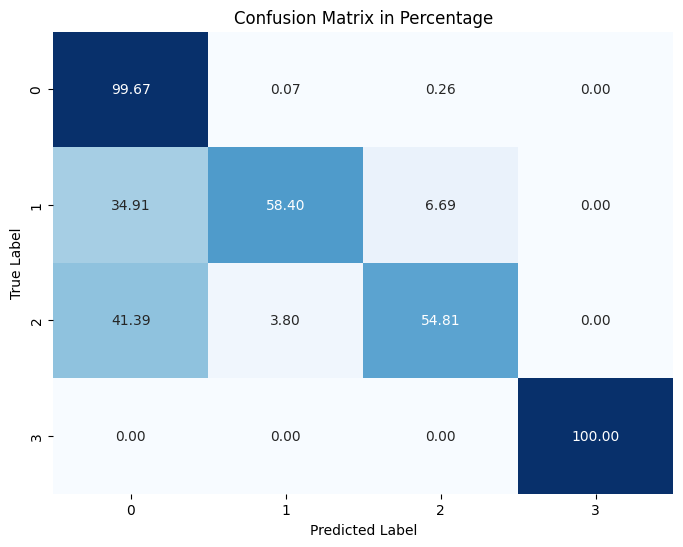

In [22]:
cmat = tf.math.confusion_matrix(labels=y_test, predictions=predicted)

plt.figure(figsize=(3,3))
sns.heatmap(cmat, annot=True, fmt='d')
plt.xlabel('prediction')
plt.ylabel('ground truth')



cm = tf.math.confusion_matrix(y_test, predicted)

# Convert EagerTensor to NumPy array
cm_np = cm.numpy()

# Row-wise normalization to get percentages
cm_percentage = cm_np.astype('float') / cm_np.sum(axis=1)[:, np.newaxis] * 100

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix in Percentage')
plt.show()

In [23]:
# import keras
model.save("Multiclass_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
# import keras
model.save("Multiclass_model.keras")